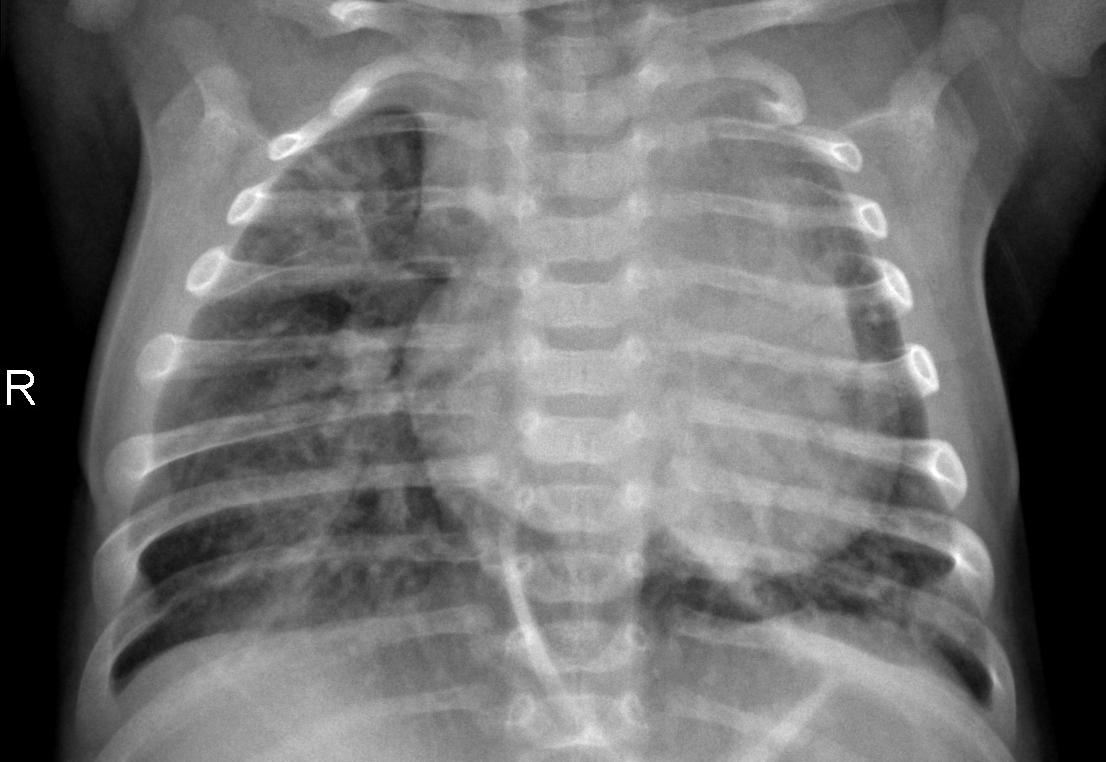
----
**Training a Hyper-model on chest X-ray**



The hypermodel implementation aimed to significantly improve diagnostic performance on the chest X-ray pneumonia classification task by incorporating more advanced training techniques and model architecture. Building upon the EfficientNet-B3 backbone, the code introduced a robust pipeline that includes extensive data augmentation, adaptive learning rate scheduling, early stopping to prevent overfitting, and evaluation with detailed metrics such as a confusion matrix and classification report. The goal was not only to achieve higher accuracy but also to ensure the model's reliability in distinguishing between normal and pneumonia cases across unseen data. By systematically optimizing the training process and incorporating real-world diagnostic evaluation tools, this hypermodel represents a more practical and powerful approach to medical image classification, setting the stage for deployment or further clinical research.










Loaded pretrained weights for efficientnet-b3


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1: Train Loss=0.1580, Val Loss=0.8874, Val Acc=56.25%
Epoch 2: Train Loss=0.0542, Val Loss=0.3932, Val Acc=75.00%
Epoch 3: Train Loss=0.0368, Val Loss=0.1115, Val Acc=100.00%
Epoch 4: Train Loss=0.0296, Val Loss=0.1094, Val Acc=100.00%
Epoch 5: Train Loss=0.0262, Val Loss=0.0189, Val Acc=100.00%
Epoch 6: Train Loss=0.0173, Val Loss=0.0486, Val Acc=100.00%
Early stopping triggered.

✅ Classification Report:

              precision    recall  f1-score   support

      NORMAL       0.98      0.56      0.71       234
   PNEUMONIA       0.79      0.99      0.88       390

    accuracy                           0.83       624
   macro avg       0.89      0.78      0.80       624
weighted avg       0.86      0.83      0.82       624



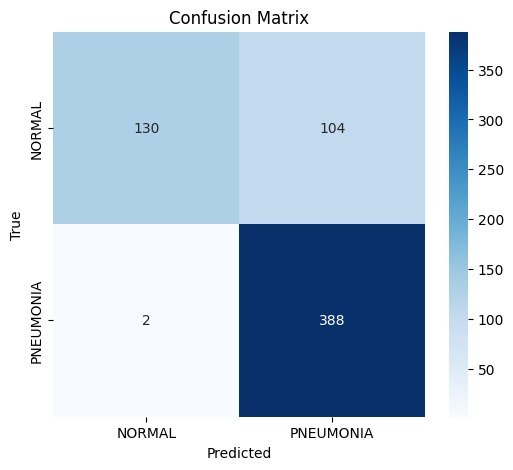

In [1]:
# Install necessary libraries
!pip install kagglehub --quiet
!pip install efficientnet_pytorch --quiet
!pip install scikit-learn --quiet

#  Import libraries
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from efficientnet_pytorch import EfficientNet
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import kagglehub

#  Download and set dataset paths
dataset_path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
train_dir = os.path.join(dataset_path, "chest_xray", "train")
val_dir = os.path.join(dataset_path, "chest_xray", "val")
test_dir = os.path.join(dataset_path, "chest_xray", "test")

#  Data transforms with augmentation
train_transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Grayscale
])

test_transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

#  Load data
train_data = datasets.ImageFolder(train_dir, transform=train_transform)
val_data = datasets.ImageFolder(val_dir, transform=test_transform)
test_data = datasets.ImageFolder(test_dir, transform=test_transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EfficientNet.from_pretrained('efficientnet-b3', num_classes=2)
model = model.to(device)

#  Optimizer, loss, scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, verbose=True)

#  Training and validation
def train(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(loader)

def evaluate(model, loader, criterion):
    model.eval()
    total = 0
    correct = 0
    loss_sum = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss_sum += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return loss_sum / len(loader), 100 * correct / total

#  Training loop with early stopping
best_val_acc = 0
patience = 3
counter = 0

epochs = 15
for epoch in range(epochs):
    train_loss = train(model, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate(model, val_loader, criterion)
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_acc:.2f}%")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

#  Load best model
model.load_state_dict(torch.load("best_model.pth"))

#  Evaluate on test set
def test_model(model, loader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.numpy())
            y_pred.extend(preds.cpu().numpy())
    return y_true, y_pred

y_true, y_pred = test_model(model, test_loader)

print("\n Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=test_data.classes))

#  Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=test_data.classes, yticklabels=test_data.classes, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
